# Residual connection

A simple investigation of the way a residual connection works.

In [106]:
import torch
from torch import nn
import torch.nn.functional as F

import torchvision as tv

from tqdm import tqdm, trange

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Charter"

RED  = '#B13E26'
LRED = '#D38473'
BLUE = '#306693'
LBLUE = '#86B3D9'
GREEN = '#677d00'
LGREEN = '#acd373'
ORANGE = '#E69500'

def basic(ax=None):
    """
    Clean axes

    :param axes:
    :return:
    """

    if ax is None:
        ax = plt.gca()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


In [99]:
def smoothed(x, y, nsmooth=10, ax=None, *args, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    ys = []
    for i, v in enumerate(y):
        fr = max(0, i-nsmooth+1)
        chunk = y[fr:i+1]
        ys.append(sum(chunk)/len(chunk))

    ax.plot(x, y, alpha=0.2, *args, **kwargs)
    ax.plot(x, ys, alpha=1., *args, **kwargs)

In [19]:
# import MNIST
batch_size=32

h, w = 32, 32
# Load MNIST and scale up to 32x32, with color channels
transform = tv.transforms.Compose(
    [tv.transforms.Grayscale(num_output_channels=3),
     tv.transforms.Resize((h, w)),
     tv.transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [54]:
class Net(nn.Module):
    
    def __init__(self, res=True):
        super().__init__()

        self.res = res

        # block 1
        self.b1c1 = nn.Conv2d(3, 16, 3, padding='same')
        self.b1c2 = nn.Conv2d(16, 16, 3, padding='same')
        self.b1c3 = nn.Conv2d(16, 64, 1, padding='same')

        # block 2
        self.b2c1 = nn.Conv2d(64, 64, 3, padding='same')
        self.b2c2 = nn.Conv2d(64, 64, 3, padding='same')

        self.cls = nn.Linear(2 * 2 * 64, 10)
        
    def forward(self, x):

        b, c, h, w = x.size()

        # block 1
        x = F.relu(self.b1c1(x))
        x = F.relu(self.b1c2(x))
        x = self.b1c3(x) # no relu here

        x = F.max_pool2d(x, 4)

        self.x_res = x.clone() # remember for the residual
        self.x_in = x.clone()  # remember input to block2

        self.x_res.retain_grad()
        self.x_in.retain_grad()

        #block 2

        x = F.relu(self.b2c1(self.x_in))
        x = F.relu(self.b2c2(x))

        if self.res:
            x = x + self.x_res
        
        x = F.max_pool2d(x, 4)

        return self.cls(x.reshape(b, -1))

In [55]:
model = Net()
opt = torch.optim.Adam(lr=3e-4, params=model.parameters())

losses = []
x_res_norms = []
x_in_norms = []

for i (x, t_ in (bar := tqdm(enumerate(dataloader_)):
    opt.zero_grad()
    
    o = model(x)
    loss = F.cross_entropy(o, t)
    loss.backward()

    losses.append(loss.item())
    x_res_norms.append(model.x_res.grad.norm(2).item())
    x_in_norms.append(model.x_in.grad.norm(2).item())

    opt.step()
    
    bar.set_postfix({ 'loss': f'{loss.item():.2}' })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:55<00:00, 34.05it/s, loss=0.05]


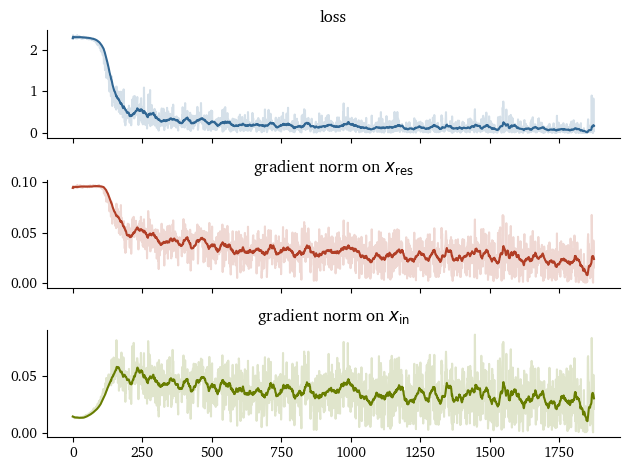

In [108]:
assert len(losses) == len(x_res_norms) == len(x_in_norms)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)

x = range(len(losses))

smoothed(x, losses, nsmooth=20, color=BLUE, ax=ax1)
basic(ax=ax1)
ax1.set_title('loss')

smoothed(x, x_res_norms, nsmooth=20, color=RED, ax=ax2)
basic(ax=ax2)
ax2.set_title('gradient norm on $x_\\text{res}$')

smoothed(x, x_in_norms, nsmooth=20, color=GREEN, ax=ax3)
basic(ax=ax3)
ax3.set_title('gradient norm on $x_\\text{in}$')

plt.tight_layout()

plt.savefig('../images/residual-experiment.svg')